In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [6]:
print(train.dtypes)

Id                 int64
MSSubClass         int64
MSZoning           int64
LotFrontage      float64
LotArea            int64
Street             int64
Alley              int64
LotShape           int64
LandContour        int64
Utilities          int64
LotConfig          int64
LandSlope          int64
Neighborhood       int64
Condition1         int64
Condition2         int64
BldgType           int64
HouseStyle         int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle          int64
RoofMatl           int64
Exterior1st        int64
Exterior2nd        int64
MasVnrType         int64
MasVnrArea       float64
ExterQual          int64
ExterCond          int64
Foundation         int64
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual        int64
TotRmsAbvGrd       int64
Functional         int64
Fireplaces         int64
FireplaceQu        int64
GarageType         int64
GarageYrBlt      float64


In [5]:
# string label to categorical values
from sklearn.preprocessing import LabelEncoder

for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

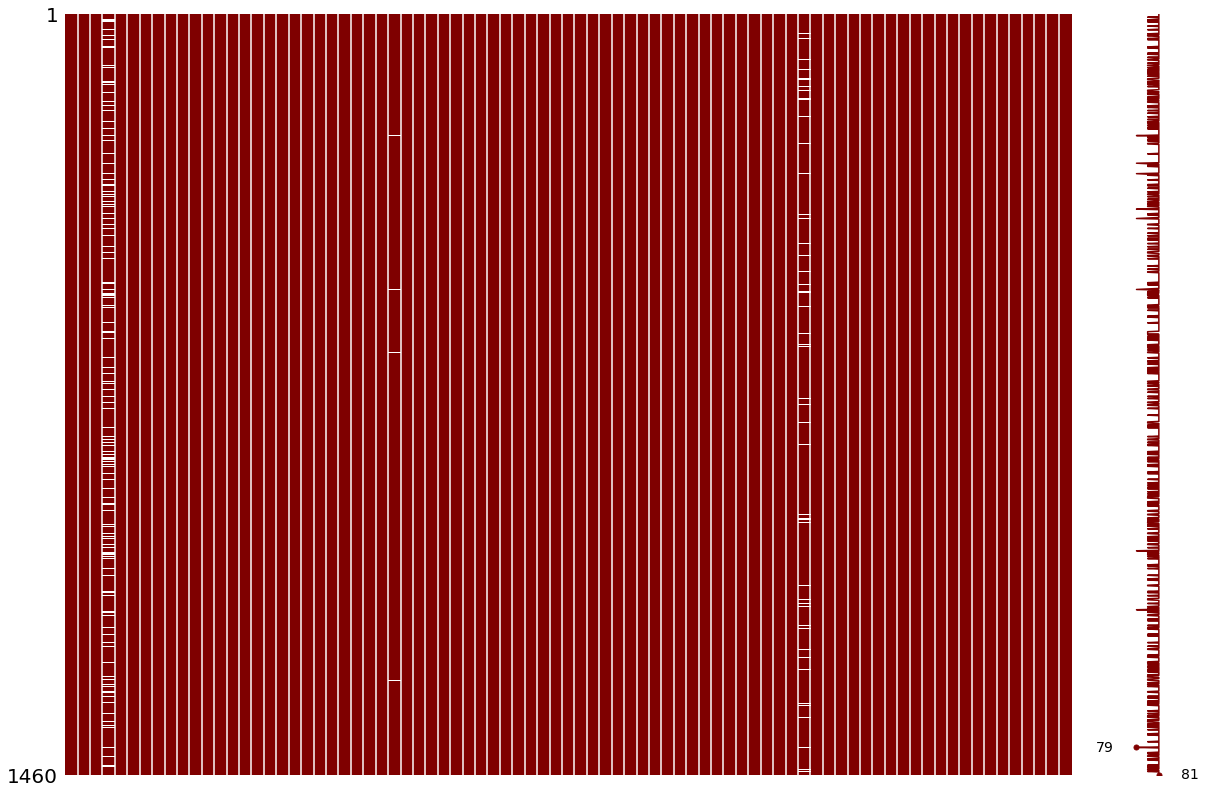

In [15]:
# search for missing data
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [22]:
# Which columns have nan?
print('training data+++++++++++++++++++++')
for i in np.arange(train.shape[1]):
    n = train.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(train.columns.values)[i] + ': ' + str(n) + ' nans')

print('testing data++++++++++++++++++++++ ')
for i in np.arange(test.shape[1]):
    n = test.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(test.columns.values)[i] + ': ' + str(n) + ' nans')

training data+++++++++++++++++++++
LotFrontage: 259 nans
MasVnrArea: 8 nans
GarageYrBlt: 81 nans
testing data++++++++++++++++++++++ 
LotFrontage: 227 nans
MasVnrArea: 15 nans
BsmtFinSF1: 1 nans
BsmtFinSF2: 1 nans
BsmtUnfSF: 1 nans
TotalBsmtSF: 1 nans
BsmtFullBath: 2 nans
BsmtHalfBath: 2 nans
GarageYrBlt: 78 nans
GarageCars: 1 nans
GarageArea: 1 nans


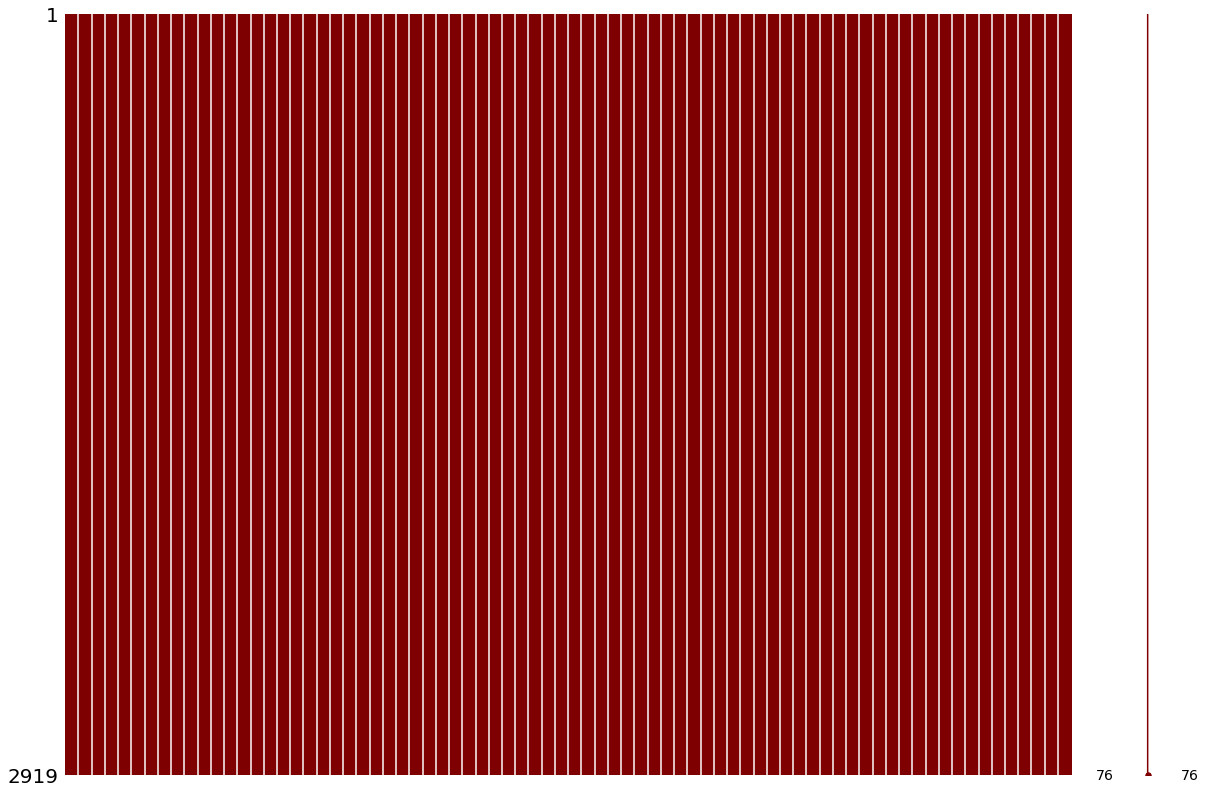

In [23]:
# keep ID for submission
train_ID = train['Id']
test_ID = test['Id']

# split data for training
y_train = train['SalePrice']
X_train = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)

# dealing with missing data
Xmat = pd.concat([X_train, X_test])
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Xmat = Xmat.fillna(Xmat.median())

# check whether there are still nan
import missingno as msno
msno.matrix(df=Xmat, figsize=(20,14), color=(0.5,0,0))

In [24]:
# add a new feature 'total sqfootage'
Xmat['TotalSF'] = Xmat['TotalBsmtSF'] + Xmat['1stFlrSF'] + Xmat['2ndFlrSF']
print('There are currently ' + str(Xmat.shape[1]) + ' columns.')

There are currently 77 columns.


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


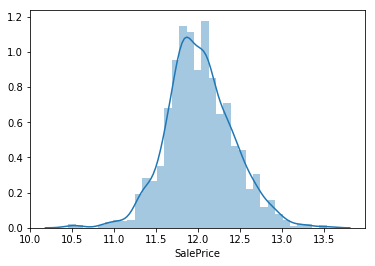

In [19]:
y_train = np.log(y_train)
ax = sns.distplot(y_train)
plt.show()

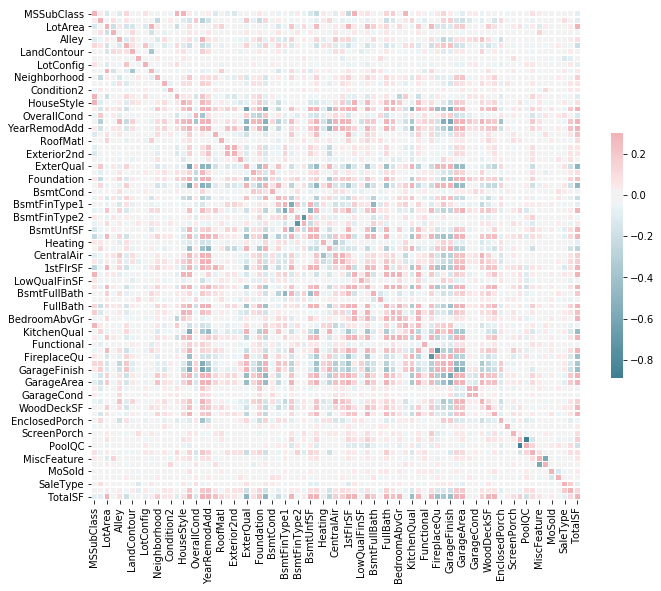

In [25]:
# train and test
X_train = Xmat.iloc[:train.shape[0],:]
X_test = Xmat.iloc[train.shape[0]:,:]

# Compute the correlation matrix
corr = X_train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Training done using Random Forest


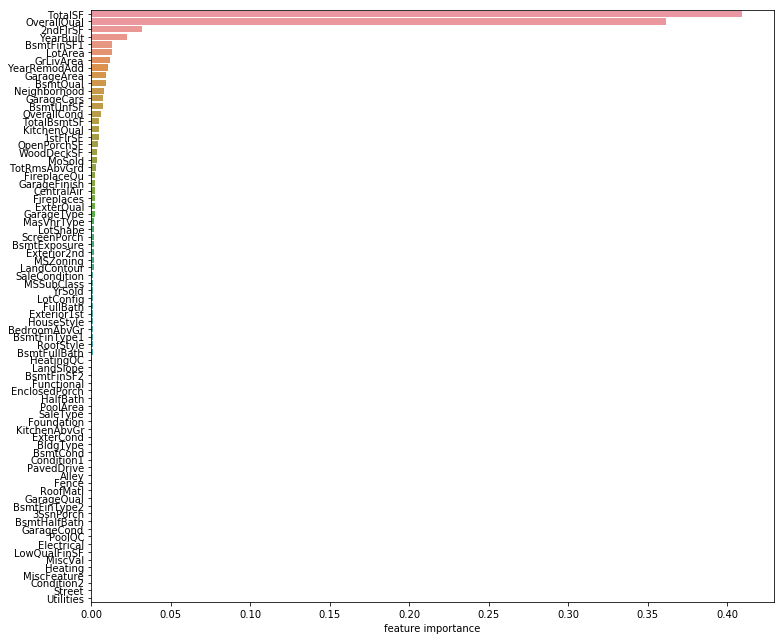

In [26]:
# feature importance using random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

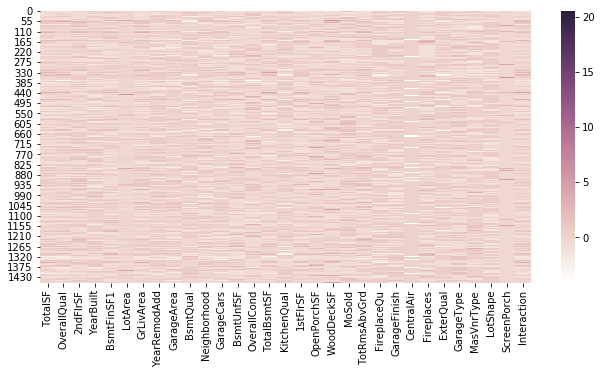

In [27]:
# use the top 30 features only
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]

# interaction between the top 2
X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

# zscoring
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
    
# heatmap
f, ax = plt.subplots(figsize=(11, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(X_train, cmap=cmap)
plt.show()

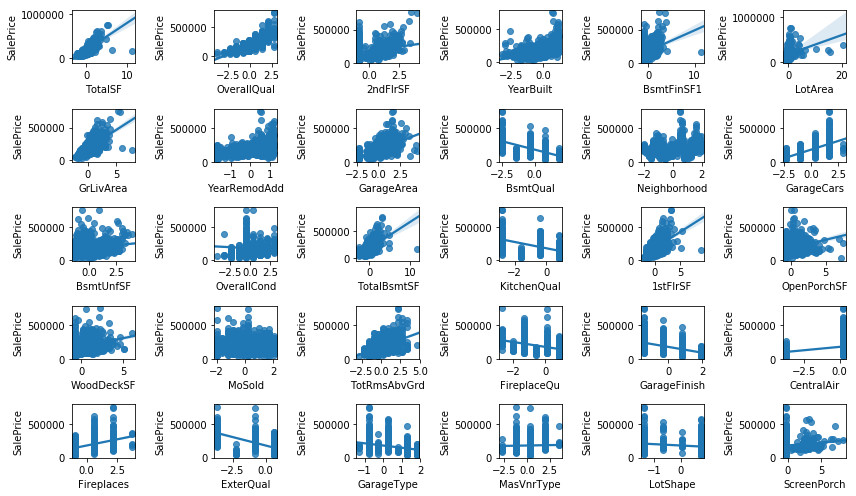

In [28]:
# relation to the target
fig = plt.figure(figsize=(12,7))
for i in np.arange(30):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

In [29]:
# outlier deletion
Xmat = X_train
Xmat['SalePrice'] = y_train
Xmat = Xmat.drop(Xmat[(Xmat['TotalSF']>5) & (Xmat['SalePrice']<12.5)].index)
Xmat = Xmat.drop(Xmat[(Xmat['GrLivArea']>5) & (Xmat['SalePrice']<13)].index)

# recover
y_train = Xmat['SalePrice']
X_train = Xmat.drop(['SalePrice'], axis=1)

In [32]:
# XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train, y_train)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    6.9s finished


0.8827227695651302
{'max_depth': 2, 'n_estimators': 200}


In [33]:
# SVR
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

reg_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg_svr.fit(X_train, y_train)

print(reg_svr.best_score_)
print(reg_svr.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.6181226112102107
{'C': 1000.0, 'gamma': 0.01}


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
epochs = [10, 50, 100]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
reg_dl.fit(X_train, y_train)

print(reg_dl.best_score_)
print(reg_dl.best_params_)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
X_train2 = pd.DataFrame( {
    'XGB': reg_xgb.predict(X_train),
    'SVR': reg_svr.predict(X_train),
})
X_train2.head()

,XGB,SVR
0,200846.531250,192976.734889
1,180623.171875,175137.401253
2,211381.187500,202096.035717
3,164193.203125,167947.083121
4,294174.125000,246583.442143


In [36]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)

# prediction using the test set
X_test2 = pd.DataFrame( {
    'XGB': reg_xgb.predict(X_test),
    'SVR': reg_svr.predict(X_test),
})

# Don't forget to convert the prediction back to non-log scale
y_pred = np.exp(reg.predict(X_test2))

In [37]:
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_pred
})
submission.to_csv('houseprice.csv', index=False)